# [IAPR 2018:][iapr2018] Lab 1 ‒  Image segmentation

**Author:** Axel Manguy
**Due date:** 20.04.2018
**Group:** Quentin Desaulty, Axel Manguy

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

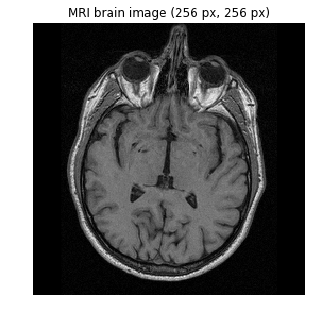

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing


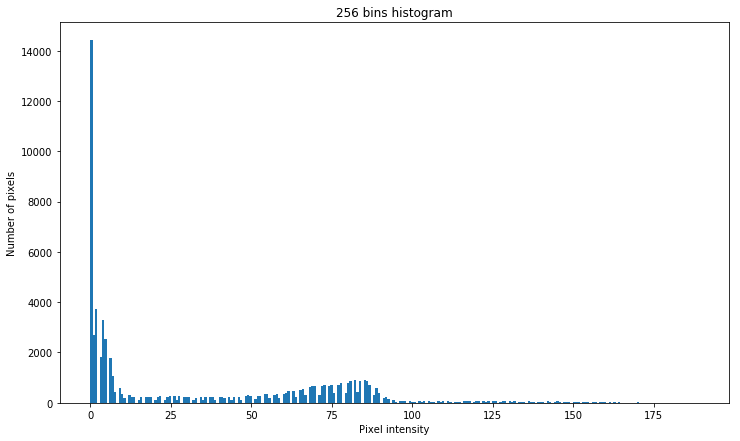

The threshold seems to be around 70


In [4]:
#Histogram computation
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
nb_bins = 256

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()
print('The threshold seems to be around 70')

The size of the brain is 11529 pixels


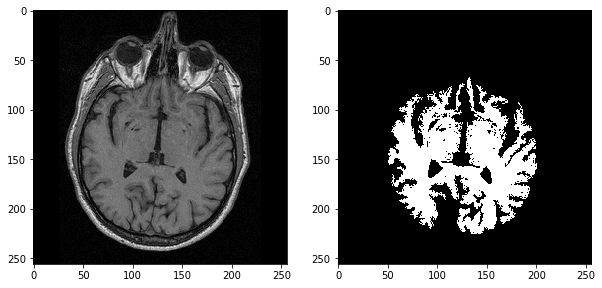

In [5]:
import numpy as np
import skimage.io
from collections import Counter
from skimage import morphology
import matplotlib.pyplot as plt

THRESHOLD = 71
SEED = (127, 162)

def regionGrowing(z, bi, bs, seed):
    neighbours = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
    mask = np.zeros_like(z, dtype = bool)
    stack = [seed] # push start coordinate on stack
    while stack:
        x, y = stack.pop()
        mask[x, y] = True
        
        for dx, dy in neighbours:
            nx, ny = x + dx, y + dy
            if (0 <= nx < z.shape[0]) and (0 <= ny < z.shape[1]) and (not mask[nx, ny]) and (z[nx, ny] <= bs) and (z[nx, ny] >= bi):
                stack.append((nx, ny))
    return mask

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# plot original image
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 10))
ax1.imshow(brain_im, cmap='gray')

#Region growing
#Threshold put to 71 after histogram evaluation
#Seed humanly determined
merged = regionGrowing(brain_im, THRESHOLD, 255, SEED)

ax2.imshow(merged, cmap='gray')

x=np.sum(merged)
print('The size of the brain is {} pixels'.format(x))



The brains seems to be well detected but a bit is missing in the lower part of the brain. Even if the cranial cavity isn't visible, some part of the brain are missing 


### 1.3 Contour detection

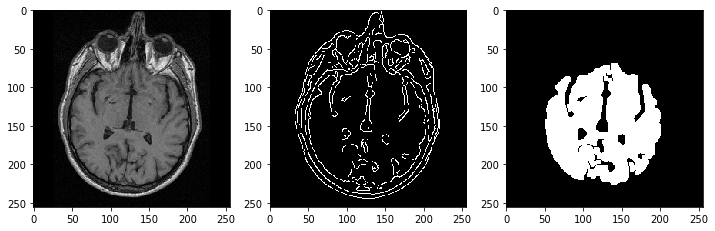

The size of the brain is 16048 pixels


In [6]:
import numpy as np
import skimage.io
from skimage import feature
from skimage import filters
from collections import Counter
from skimage import morphology
import matplotlib.pyplot as plt

def regionGrowingBoolean(z, seed):
    neighbours = [(-1,0), (0,1), (1,0), (0,-1)]
    mask = np.zeros_like(z, dtype = bool)
    stack = [seed] # push start coordinate on stack
    while stack:
        x, y = stack.pop()
        mask[x, y] = True
        for dx, dy in neighbours:
            nx, ny = x + dx, y + dy
            if (0 <= nx < z.shape[0]) and (0 <= ny < z.shape[1]) and (not mask[nx, ny]) and z[nx, ny]:
                stack.append((nx, ny))
    return mask

# Edge detection
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))
ax1.imshow(brain_im, cmap='gray')

#filter application befofre countour detection
#for noise attenuation
#value determined by hand
filtered = filters.median(brain_im, np.ones((4, 4)))
filtered = filters.median(filtered, np.ones((6, 6)))

#contour detection 
edges2 = feature.canny(filtered, sigma=0.5)
ax2.imshow(edges2, cmap='gray')

#binary morphology operations to close the lines
edges2 = morphology.binary_closing(edges2, np.ones((5, 5)))
edges2 = ~edges2

#region growing without threshold, seed from experience
merged = regionGrowingBoolean(edges2, (110, 140))
ax3.imshow(merged, cmap='gray')

plt.show()

x=np.sum(merged)
print('The size of the brain is {} pixels'.format(x))

The brains is now complete(no part missing)


### 1.4 active contour

the idea of active contour is to begin with a circle aroud (or inside) the sape whe want to extract and to reduce it (or expand). The active contour seems to have difficulties to identify the brain since its shape is complexe and included in another one.

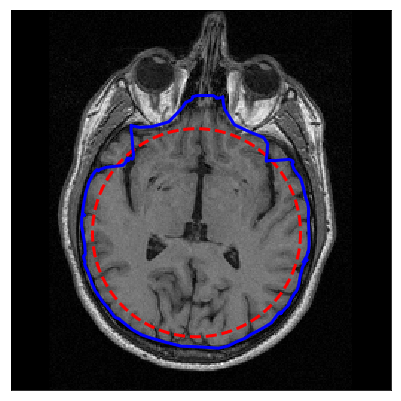

In [7]:
#exemple taken from scikit image documentation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

#external circle definition
s = np.linspace(0, 2*np.pi, 400)
x = 125 + 70*np.cos(s)
y = 150 + 70*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(brain_im,3),
                       init, alpha=1e-3, beta=1e-4, gamma=0.001,w_line =-0.6)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(brain_im, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, brain_im.shape[1], brain_im.shape[0], 0])
plt.show()

## Part 2: Shape/color segmentation

You will find hereafter a picture of shapes of different colors, taken under four different illuminations.
We ask you to create a routine to:
1. Count the number of shapes of each color.
1. Compute the total area (in pixels) of each color.

One specific challenge is to be robust to illumination changes.
Try to have the same routine(s) running on the four images, and giving (approximatively) the same results.
Therefore some kind of intensity normalization should probably be used.
To help you, you will also find a reference image (palette) with disks of each possible color, that you can use as references.

**Note:** the routine(s) that you will write for this part will be useful for the robot project as well, so pay special attention to it.

### 2.1 Images and palette visualization

In [8]:
# Load images
import tarfile
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)

im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  4
Image size: 480, 640 
Number of color channels:  3


### 2.2 Number of shapes of each color
The implementation is detailed in section 2.4.
The results are given here for all 4 images. The errors made by the color detector in LAB color space are well corrected and all images gave the same results

In [9]:
import numpy as np
import skimage.io
from skimage import feature
from skimage import filters
from skimage import measure
from skimage import exposure
from collections import Counter
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage import morphology
import matplotlib.pyplot as plt
from skimage.color import convert_colorspace
from skimage.color import rgb2grey
from scipy import ndimage as ndi
from skimage.color import rgb2lab,deltaE_ciede2000

def color_detection(im,origin,color_data_hsv,color_data_lab,color_data_rgb,props):
    #region properties
    y0, x0 = props.centroid
    
    #image conversion from rgb to lab and hsv
    #both original and modifed are converted
    im_lab = rgb2lab(im)
    origin_lab = rgb2lab(origin)
    im_hsv = convert_colorspace(im, 'RGB','HSV')
    origin_hsv = convert_colorspace(origin, 'RGB','HSV')
    
    #the center of the region is selected large enough to have a significant mean
    #and small enough not to take the bacground or the edges
    select_lab=im_lab[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]
    select_o_lab=origin_lab[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]
    select_hsv=im_hsv[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]
    select_o_hsv=origin_hsv[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]

    color=['red','yellow','green','brown','blue','purple','grey']
    
    #the color used for detection is the mean of the previous selection
    #for each chanel
    curent_color_lab = np.array([select_lab[:,:, i].mean() for i in range(3)])
    curent_color_o_lab = np.array([select_o_lab[:,:, i].mean() for i in range(3)])
    curent_color_hsv = np.array([select_hsv[:,:, i].mean() for i in range(3)])
    curent_color_o_hsv = np.array([select_o_hsv[:,:, i].mean() for i in range(3)])
    
    #distance vectors store all the distances between the reference palette and the curent color
    #euclidiean distance is use for hsv and a more adapted one for lab
    dist_hsv = np.sum(np.power(color_data_hsv - curent_color_hsv,2),1)
    dist_o_hsv=np.sum(np.power(color_data_hsv - curent_color_o_hsv,2),1)
    dist_lab = np.array([deltaE_ciede2000(color_ref,curent_color_lab) for color_ref in color_data_lab])
    dist_o_lab = np.array([deltaE_ciede2000(color_ref,curent_color_o_lab) for color_ref in color_data_lab])
    
    #the indice corresponds to the minimum of distance
    ind_hsv=np.argmin(dist_hsv)
    ind_o_hsv=np.argmin(dist_o_hsv)
    ind_lab=np.argmin(dist_lab)
    ind_o_lab=np.argmin(dist_o_lab)

    candidates = np.array([color[ind_lab],color[ind_o_lab],
                           color[ind_hsv],color[ind_o_hsv]])
    
    #the lab seems to have the best selection at first
    best_color=color[ind_lab]
    #if there is an ambiguity between the modified image (rescaled) and the original
    if color[ind_lab] != color[ind_o_lab] or color[ind_hsv] != color[ind_o_hsv]:
        candidate_lst,counts = np.unique(candidates, return_counts=True)
        #if there is 2 best candidate
        if sorted(counts)[-1]==2:
            #just take the shortest 
            #surprisingly the both distance have the same order of magnitude
            candidates = np.array([color[ind_lab],color[ind_o_lab],
                                   color[ind_hsv],color[ind_o_hsv]])
            distance=np.array([dist_lab[ind_lab],dist_o_lab[ind_o_lab],
                               dist_hsv[ind_hsv],dist_o_lab[ind_o_hsv]])
            best_color = candidates[np.argmin(distance)]
        else:
            #if there is no more ambiguity,the better is the more frequent one
            best_color = candidate_lst[np.argmax(counts)]
            
    return best_color
        
    

/root/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


There is 1.0 red shape(s) (1.0 rectangles, 0.0 circle and 0.0 triangle)
There is 1.0 yellow shape(s) (0.0 rectangles, 1.0 circle and 0.0 triangle)
There is 3.0 green shape(s) (1.0 rectangles, 1.0 circle and 1.0 triangle)
There is 1.0 brown shape(s) (1.0 rectangles, 0.0 circle and 0.0 triangle)
There is 3.0 blue shape(s) (2.0 rectangles, 0.0 circle and 1.0 triangle)
There is 2.0 purple shape(s) (0.0 rectangles, 0.0 circle and 2.0 triangle)
There is 1.0 grey shape(s) (0.0 rectangles, 1.0 circle and 0.0 triangle)


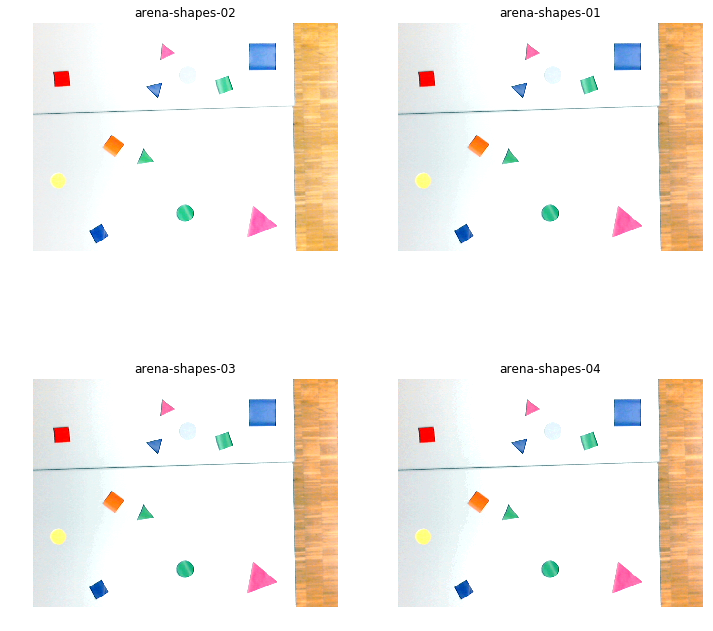

In [10]:
#contour detection 

#colors importation
palette_rgb = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
pos=[48,136,220,311,392,484,578]
col=['red','yellow','green','brown','blue','purple','grey']
x=44
colors={}
color_data_lab=[]
color_data_rgb=[]
color_data_hsv=[]
#modify colors coordinates
#the point is to use a less corellated system of color representation
palette_hsv = convert_colorspace(palette_rgb, 'RGB','HSV')
palette_lab= rgb2lab(palette_rgb)
for i,y in enumerate(pos):
    colors[i]=col[i]
    color_data_lab.append(palette_lab[y,x,:])
    color_data_hsv.append(palette_hsv[y,x,:])
    color_data_rgb.append(palette_rgb[y,x,:])

#image importation
im_names = ['arena-shapes-02', 'arena-shapes-01', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

#initilisation the final dict containing all the area values by colors
imagescolors={c:0 for c in colors.values() }
shapecolors={c:{'rectangle':0,'circle':0,'triangle':0} for c in colors.values() }
colorlocation={}

for ax, im, nm in zip(axes.ravel(), images, im_names):
    #grey scale image to compute shape
    origin=im.copy()
    grey=rgb2grey(im)
    
    #grey_equalized=exposure.equalize_hist(grey)
    #median filter to get better image 
    filtered = filters.median(grey, np.ones((1, 1)))
    
    #intensity correction
    p2 = np.percentile(filtered, 2)
    p98 = np.percentile(filtered, 98)
    filtered_equalized = exposure.rescale_intensity(filtered, in_range=(p2, p98))

    #contour detection
    edges = feature.canny(filtered_equalized, sigma=0.1)
    
    #fill to edges to get area
    filled = ndi.binary_fill_holes(edges)
    
    #binary morphology to make the dotted lines to disapear
    opened = morphology.binary_opening(filled, np.ones((9, 9)))
    
    #regions detections
    label_img = measure.label(opened)
    regions = measure.regionprops(label_img)
    
    #Intensity rescale for each chanel
    p1 = np.percentile(im[:,:,0], 0.1)
    p40 = np.percentile(im[:,:,0], 40)
    im[:,:,0] = exposure.rescale_intensity(im[:,:,0], in_range=(p1, p40))
    p1 = np.percentile(im[:,:,1], 0.1)
    p40 = np.percentile(im[:,:,1], 40)
    im[:,:,1] = exposure.rescale_intensity(im[:,:,1], in_range=(p1, p40))
    p1 = np.percentile(im[:,:,2], 0.1)
    p50 = np.percentile(im[:,:,2], 40)
    im[:,:,2] = exposure.rescale_intensity(im[:,:,2], in_range=(p1, p40))
    
    for props in regions:
        #center of the region
        y0, x0 = props.centroid
        
        #color detection
        curent_color=color_detection(im,origin,color_data_hsv,color_data_lab,color_data_rgb,props)
        #print("--->"+curent_color)
        
        #Shape detection        
        minr, minc, maxr, maxc = props.bbox
        shape=filtered_equalized[minr-15:maxr+15, minc-15:maxc+15]
        coords = corner_peaks(corner_harris(shape), min_distance=5)
       
        #complete the colors dictionary
        if len(coords)==0:
            shapecolors[curent_color]['circle']+=1
        elif len(coords)==3:
            shapecolors[curent_color]['triangle']+=1
        elif len(coords)==4 or len(coords)==2:
            shapecolors[curent_color]['rectangle']+=1
        else:
            print('weird number of corners')
            
       
    #show result
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
    
for key,value in shapecolors.items():
    print('There is {} {} shape(s) ({} rectangles, {} circle and {} triangle)'.format(np.sum(list(value.values()))/4,
                                                                                      key,
                                                                                      (list(value.values())[0]/4),
                                                                                      (list(value.values())[1]/4),
                                                                                      (list(value.values())[2]/4)))

### 2.3 Total area (in pixels) of each color

The functions and the process are the same as before and explained in 2.4. To count the number of pixel, the area(props.area) is added for each category.

In [9]:
#contour detection 

#colors importation
palette_rgb = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
pos=[48,136,220,311,392,484,578]
col=['red','yellow','green','brown','blue','purple','grey']
colors={}
color_data_lab=[]
color_data_rgb=[]
color_data_hsv=[]
#palette from others color space (hsv and lab)
palette_hsv = convert_colorspace(palette_rgb, 'RGB','HSV')
palette_lab= rgb2lab(palette_rgb)
for i,y in enumerate(pos):
    colors[i]=col[i]
    color_data_lab.append(palette_lab[y,x,:])
    color_data_hsv.append(palette_hsv[y,x,:])
    color_data_rgb.append(palette_rgb[y,x,:])

#image importation
im_names = ['arena-shapes-02', 'arena-shapes-01', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)

#final dict initialisation
imagescolors={c:0 for c in colors.values() }
shapecolors={c:{'rectangle':0,'circle':0,'triangle':0} for c in colors.values() }
colorlocation={}

for ax, im, nm in zip(axes.ravel(), images, im_names):
    #grey scale image to compute shape
    origin=im.copy()
    grey=rgb2grey(im)
    
    #grey_equalized=exposure.equalize_hist(grey)
    #median filter to get better image 
    filtered = filters.median(grey, np.ones((1, 1)))
    
    #intensity correction
    p2 = np.percentile(filtered, 2)
    p98 = np.percentile(filtered, 98)
    filtered_equalized = exposure.rescale_intensity(filtered, in_range=(p2, p98))

    #contour detection
    edges = feature.canny(filtered_equalized, sigma=0.1)
    
    #fill to edges to get area
    filled = ndi.binary_fill_holes(edges)
    
    #binary morphology to make the dotted lines to disapear
    opened = morphology.binary_opening(filled, np.ones((9, 9)))
    
    #regions detections
    label_img = measure.label(opened)
    regions = measure.regionprops(label_img)
    
    #Intensity rescale for each chanel
    p1 = np.percentile(im[:,:,0], 0.1)
    p40 = np.percentile(im[:,:,0], 40)
    im[:,:,0] = exposure.rescale_intensity(im[:,:,0], in_range=(p1, p40))
    p1 = np.percentile(im[:,:,1], 0.1)
    p40 = np.percentile(im[:,:,1], 40)
    im[:,:,1] = exposure.rescale_intensity(im[:,:,1], in_range=(p1, p40))
    p2 = np.percentile(im[:,:,2], 0.1)
    p50 = np.percentile(im[:,:,2], 40)
    im[:,:,2] = exposure.rescale_intensity(im[:,:,2], in_range=(p1, p40))
    
    for props in regions:
        #center of the region
        y0, x0 = props.centroid
        
        #color detection
        curent_color=color_detection(im,origin,color_data_hsv,color_data_lab,color_data_rgb,props)
        #print("--->"+curent_color)
        
        #Shape detection        
        minr, minc, maxr, maxc = props.bbox
        shape=filtered_equalized[minr-15:maxr+15, minc-15:maxc+15]
        coords = corner_peaks(corner_harris(shape), min_distance=5)
       
        #complete the colors dictionary
        if len(coords)==0:
            shapecolors[curent_color]['circle']+=props.area
        elif len(coords)==3:
            shapecolors[curent_color]['triangle']+=props.area
        elif len(coords)==4 or len(coords)==2:
            shapecolors[curent_color]['rectangle']+=props.area
        else:
            print('weird number of corners')

for key,value in shapecolors.items():
        print('There is {} pixels of {} shape(s) ({} px of rectangles, {} px of circle and {} px triangle)'.format(int(np.sum(list(value.values()))/4),
                                                                                      key,
                                                                                      int(list(value.values())[0]/4),
                                                                                      int(list(value.values())[1]/4),
                                                                                      int(list(value.values())[2]/4)))

/root/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


There is 1160 pixels of red shape(s) (1160 px of rectangles, 0 px of circle and 0 px triangle)
There is 874 pixels of yellow shape(s) (0 px of rectangles, 874 px of circle and 0 px triangle)
There is 2631 pixels of green shape(s) (977 px of rectangles, 1103 px of circle and 549 px triangle)
There is 1141 pixels of brown shape(s) (1141 px of rectangles, 0 px of circle and 0 px triangle)
There is 4807 pixels of blue shape(s) (4254 px of rectangles, 0 px of circle and 553 px triangle)
There is 2651 pixels of purple shape(s) (0 px of rectangles, 0 px of circle and 2651 px triangle)
There is 1162 pixels of grey shape(s) (0 px of rectangles, 1162 px of circle and 0 px triangle)


### 2.4 Implementation details

#### 2.4.1 Contour Detection

Several operations are made on original images to extract the shapes contours. Before applying any filter the image is transformed in grayscale (for contour and shape detection, colors doesn't matter). The noise is reduced by a median filter and the intensity is then rescaled according to the minimum and maximum value of the image(between 2 and 98 %). The contour detection is made by a canny function before some binary morphology to only extract required features

At this point, the value of the parameters are strongly dependent of the pictures. Even if these values work for all arena-shapes images, it will not for an other set of images. Finally, and in terms of automation, the human eye is required to adapt the parameters to the images.

/root/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


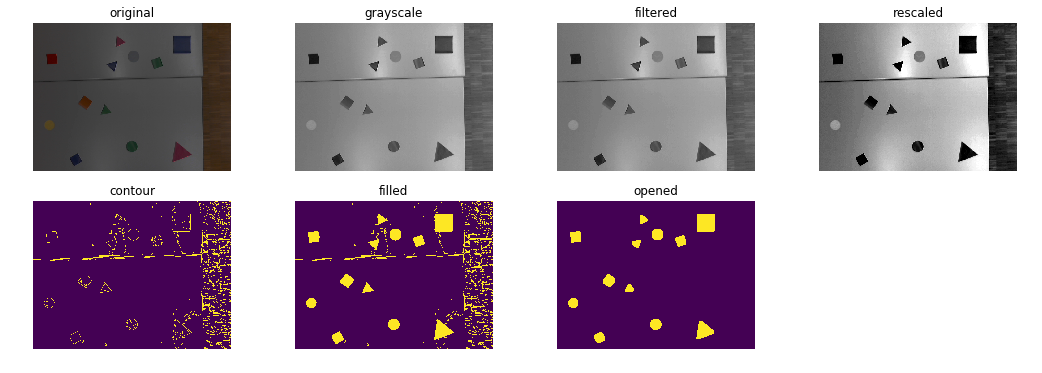

In [13]:
im_names = ['arena-shapes-02', 'arena-shapes-01', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)

im = images[0]

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7,ax8)) = plt.subplots(2, 4, figsize=(18, 6))
#grey scale image to compute shape
origin=im.copy()
ax1.imshow(origin)
ax1.axis('off')
ax1.set_title('original')
grey=rgb2grey(im)
ax2.imshow(grey,cmap='gray')
ax2.axis('off')
ax2.set_title('grayscale')

#median filter to get better image 
filtered = filters.median(grey, np.ones((1, 1)))
ax3.imshow(filtered,cmap='gray')
ax3.axis('off')
ax3.set_title('filtered')


#intensity correction
p2 = np.percentile(filtered, 2)
p98 = np.percentile(filtered, 98)
#(p2 is the value below wich 2% of the values can be found)
filtered_equalized = exposure.rescale_intensity(filtered, in_range=(p2, p98))
ax4.imshow(filtered_equalized,cmap='gray')
ax4.axis('off')
ax4.set_title('rescaled')

#contour detection
edges = feature.canny(filtered_equalized, sigma=0.1)
ax5.imshow(edges)
ax5.axis('off')
ax5.set_title('contour')


#fill to edges to get area
filled = ndi.binary_fill_holes(edges)
ax6.imshow(filled)
ax6.axis('off')
ax6.set_title('filled')

#binary morphology to make the dotted lines disapear
opened = morphology.binary_opening(filled, np.ones((9, 9)))
ax7.imshow(opened)
ax7.axis('off')
ax7.set_title('opened')
ax8.axis('off')

#regions detections
label_img = measure.label(opened)
regions = measure.regionprops(label_img)

plt.show()


#### 2.4.2 Shape Detection

To perform a shape detection, the idea is to count the vertices of the previously detected shape. This detection is made on greyscale images since color doesn't matter for shape detection. The Harris corner detector interpretes corners as a junction of two edges, where an edge is a sudden change in image brightness. When applied only on the bounding box of the region, the number of corners gives the shape.

On one rectangle, the corners detector seems to be unable to give the right number. Since it's only on one shape and due to a change of brightness on the original image,  rectangles can have 2 vertices instead of 4.

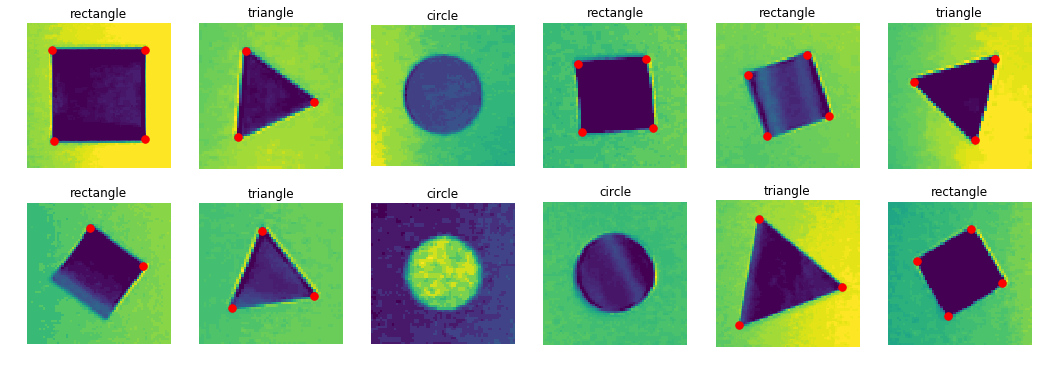

In [14]:
#regions detections
label_img = measure.label(opened)
regions = measure.regionprops(label_img)
fig,axes = plt.subplots(2, 6, figsize=(18, 6))
for ax,props in zip(axes.ravel(), regions):
    #center of the region
    y0, x0 = props.centroid

    #Shape detection        
    minr, minc, maxr, maxc = props.bbox
    shape=filtered_equalized[minr-15:maxr+15, minc-15:maxc+15]
    coords = corner_peaks(corner_harris(shape), min_distance=5)

    #complete the colors dictionary
    form='unknown'
    if len(coords)==0:
        form='circle'
    elif len(coords)==3:
        form='triangle'
    elif len(coords)==4 or len(coords)==2:
        form='rectangle'
    else:
        print('unable to perform detection')
        
    ax.imshow(shape)
    ax.plot(coords[:, 1], coords[:, 0], '.r', markersize=15)
    ax.axis('off')
    ax.set_title(form)

#### 2.4.2 Color Detection

The most difficult task here is detect colors without any errors. Before doing any measure on image, the 3 chanels have to be rebalanced to correct the brightness variations between images. The main idea is to put every shape on a white background and thus to rescale all chanels. Since the background represents the majority of the image, a way to cut it is to take the value below which all the shapes we search may be found. Using that rule and rescaling accorting to the measured percentile of each chanel, the colors values can be compared to the palette colors.

Since RGB values are strongy correlated,the euclidian distance is not representative of the visual distance between two colors. One solution is to move to another color system less correlated and better adapted to perform distance measures. In order to solve errors that could occurs two different systems are used. LAB is a color space designed to approximate human vision and HSV is a less correlated color space using Hue, Saturation and Value. The combinations of these two colors spaces applied on both original and rescaled image helps the detector to avoid errors as it brings more data in it.

When all detections doesn't agree on a color, the most proposed color is taken as the most probable proposition.
when an ambiguity is detected bewteen color propositions (in each color space and for each image), the shortest distance between all possibilities is taken as the most probable proposition (the closest to its reference color). 



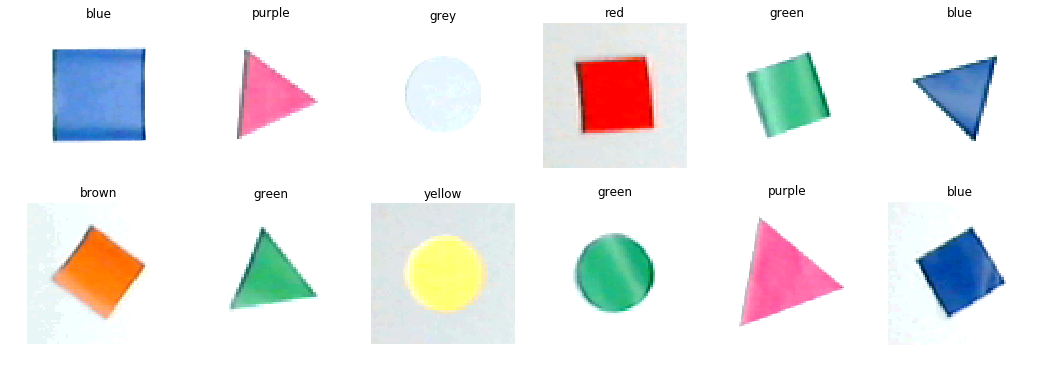

In [15]:
####################
# Palette creation #
####################

palette_rgb = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
pos=[48,136,220,311,392,484,578]
colors=['red','yellow','green','brown','blue','purple','grey']
color_data_lab=[]
color_data_rgb=[]
color_data_hsv=[]
#palette from others color space (hsv and lab)
palette_hsv = convert_colorspace(palette_rgb, 'RGB','HSV')
palette_lab= rgb2lab(palette_rgb)
for i,y in enumerate(pos):
    colors[i]=col[i]
    color_data_lab.append(palette_lab[y,x,:])
    color_data_hsv.append(palette_hsv[y,x,:])
    color_data_rgb.append(palette_rgb[y,x,:])
    
#####################
# intensity rescale #
#####################

p1 = np.percentile(im[:,:,0], 0.1)
p40 = np.percentile(im[:,:,0], 40)
im[:,:,0] = exposure.rescale_intensity(im[:,:,0], in_range=(p1, p40))

p1 = np.percentile(im[:,:,1], 0.1)
p40 = np.percentile(im[:,:,1], 40)
im[:,:,1] = exposure.rescale_intensity(im[:,:,1], in_range=(p1, p40))

p2 = np.percentile(im[:,:,2], 0.1)
p50 = np.percentile(im[:,:,2], 40)
im[:,:,2] = exposure.rescale_intensity(im[:,:,2], in_range=(p1, p40))
    
######################
# detection function #
######################
    
def color_detection(im,origin,color_data_hsv,color_data_lab,color_data_rgb,props):
    #region properties
    y0, x0 = props.centroid
    
    #image conversion from rgb to lab and hsv
    #both original and modifed are converted
    im_lab = rgb2lab(im)
    origin_lab = rgb2lab(origin)
    im_hsv = convert_colorspace(im, 'RGB','HSV')
    origin_hsv = convert_colorspace(origin, 'RGB','HSV')
    
    #the center of the region is selected large enough to have a significant mean
    #and small enough not to take the bacground or the edges
    select_lab=im_lab[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]
    select_o_lab=origin_lab[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]
    select_hsv=im_hsv[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]
    select_o_hsv=origin_hsv[int(y0-7):int(y0+7),int(x0-7):int(x0+7), :]

    color=['red','yellow','green','brown','blue','purple','grey']
    
    #the color used for detection is the mean of the previous selection
    #for each chanel
    curent_color_lab = np.array([select_lab[:,:, i].mean() for i in range(3)])
    curent_color_o_lab = np.array([select_o_lab[:,:, i].mean() for i in range(3)])
    curent_color_hsv = np.array([select_hsv[:,:, i].mean() for i in range(3)])
    curent_color_o_hsv = np.array([select_o_hsv[:,:, i].mean() for i in range(3)])
    
    #distance vectors store all the distances between the reference palette and the curent color
    #euclidiean distance is use for hsv and a more adapted one for lab
    dist_hsv = np.sum(np.power(color_data_hsv - curent_color_hsv,2),1)
    dist_o_hsv=np.sum(np.power(color_data_hsv - curent_color_o_hsv,2),1)
    dist_lab = np.array([deltaE_ciede2000(color_ref,curent_color_lab) for color_ref in color_data_lab])
    dist_o_lab = np.array([deltaE_ciede2000(color_ref,curent_color_o_lab) for color_ref in color_data_lab])
    
    #the indice corresponds to the minimum of distance
    ind_hsv=np.argmin(dist_hsv)
    ind_o_hsv=np.argmin(dist_o_hsv)
    ind_lab=np.argmin(dist_lab)
    ind_o_lab=np.argmin(dist_o_lab)

    candidates = np.array([color[ind_lab],color[ind_o_lab],
                           color[ind_hsv],color[ind_o_hsv]])
    
    #the lab seems to have the best selection at first
    best_color=color[ind_lab]
    #if there is an ambiguity between the modified image (rescaled) and the original
    if color[ind_lab] != color[ind_o_lab] or color[ind_hsv] != color[ind_o_hsv]:
        candidate_lst,counts = np.unique(candidates, return_counts=True)
        #if there is 2 best candidate
        if sorted(counts)[-1]==2:
            #just take the shortest 
            #surprisingly the both distance have the same order of magnitude
            candidates = np.array([color[ind_lab],color[ind_o_lab],
                                   color[ind_hsv],color[ind_o_hsv]])
            distance=np.array([dist_lab[ind_lab],dist_o_lab[ind_o_lab],
                               dist_hsv[ind_hsv],dist_o_lab[ind_o_hsv]])
            best_color = candidates[np.argmin(distance)]
        else:
            #if there is no more ambiguity,the better is the more frequent one
            best_color = candidate_lst[np.argmax(counts)]
            
    return best_color

#######################
# On region detection #
#######################
fig,axes = plt.subplots(2, 6, figsize=(18, 6))
for ax,props in zip(axes.ravel(), regions):
    
    #shape extraction
    minr, minc, maxr, maxc = props.bbox
    shape=im[minr-15:maxr+15, minc-15:maxc+15,:]
    
    curent_color=color_detection(im,origin,color_data_hsv,color_data_lab,color_data_rgb,props)
    ax.imshow(shape)
    ax.axis('off')
    ax.set_title(curent_color)